In [1]:
from scipy.misc import imread, imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b
from PIL import Image

import numpy as np
import time
import argparse
import warnings
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import image

from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 參數設定

In [3]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

# 設定圖片的路徑，可以玩一下，用其他圖片試試
base_image_path = 'model\\images\\content\\church.jpg'
style_image_path = 'static\\img\\styles\\udnie.jpg'
output_path = 'static\\img\\output\\'

# 設定權重
content_weight = 1
style_weight = 100
total_variation_weight = 8.5e-5

## 圖片處理函數

In [5]:
# 取得輸入圖片的長寬比例
def get_ratio(image):
    img = np.asarray(Image.open(image).convert('RGB')).astype('float')
    img_WIDTH = img.shape[0]
    img_HEIGHT = img.shape[1]
    aspect_ratio = float(img_HEIGHT) / img_WIDTH
    return aspect_ratio

# 預處理輸入的圖片
def preprocess_image(image_path):
    mode = "RGB"
    img = imread(image_path, mode=mode)

    img = imresize(img,(IMG_WIDTH, IMG_HEIGHT)).astype('float32')
    
    # 因為Library使用的格式是BGR，所以將原先的RGB圖片轉換成BGR
    # RGB -> BGR
    # img = img[:, :, ::-1]

    # img[:, :, 0] -= 103.939
    # img[:, :, 1] -= 116.779
    # img[:, :, 2] -= 123.68

    # 這個keras內建函式可以幫我們做到上面的轉換
    img = preprocess_input(img)
    
    # 檢查當前keras使用的後端引擎，如果是Theano的話需要轉換圖片陣列格式
    # Theano 格式 : (channels, rows, cols). ex: In our case - (3, 400, 400) 
    # Tensorflow 格式 : (rows, cols, channels). ex: In our case - (400, 400, 3)
    if K.image_dim_ordering() == "th":
        img = img.transpose((2, 0, 1)).astype('float32')

    # 將圖片陣列多拓展一個存放圖片數量的維度，ex: 原本是(400, 400, 3), 變成(1, 400, 400, 3)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    return img

# 後處理要輸出的圖片，將處理完的矩陣轉回去照片的格式
def deprocess_image(x):
    if K.image_dim_ordering() == "th":
        x = x.reshape((3, IMG_WIDTH, IMG_HEIGHT))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((IMG_WIDTH, IMG_HEIGHT, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # BGR -> RGB
    x = x[:, :, ::-1]

    # 將陣列的值的範圍縮回 0~255，因為處理的結果有可能出現超過這個範圍的數字
    x = np.clip(x, 0, 255).astype('uint8')
    return x

(1, 512, 512, 3)


C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


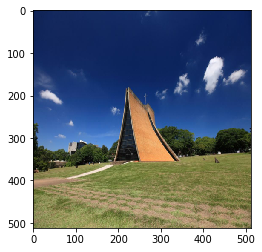

In [6]:
## 測試預處理及後處理函數
TEST_1 = preprocess_image(base_image_path)
TEST_1 = deprocess_image(TEST_1)
plt.imshow(TEST_1)

## 建立變數

In [7]:
# 建立存放經過預處理後的照片的變數
base_image = K.variable(preprocess_image(base_image_path))
style_image = K.variable(preprocess_image(style_image_path))

if K.image_dim_ordering() == 'th':
    combination_image = K.placeholder((1, 3, IMG_WIDTH, IMG_HEIGHT))
else:
    combination_image = K.placeholder((1, IMG_WIDTH, IMG_HEIGHT, 3))

image_tensors = [base_image, style_image, combination_image]
# nb = number
nb_tensors = len(image_tensors)
nb_style_images = 1 

# 將存放照片的陣列壓成一串Tensor(張量)，用於當作模型的輸入
input_tensor = K.concatenate(image_tensors, axis=0)

if K.image_dim_ordering() == "th":
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT,None)
else:
    input_shape = (None, IMG_WIDTH, IMG_HEIGHT, 3)

(1, 512, 512, 3)
(1, 512, 512, 3)


C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


## Loss Functions

In [8]:
# assert是python的語法，可以用來確定某些變數的值，當條件不滿足就會跳出警告訊息並中斷執行
# 例如 assert i == 1, 假設i不等於1就會跳出

def gram_matrix(x):
    
    # ndim: 取得張量的階數
    assert K.ndim(x) == 3
    if K.image_dim_ordering() == "th":
        features = K.batch_flatten(x)
    else:
        # batch_flatten: 將一個n階張量轉變為2階張量，其第一維度保留不變
        # permute_dimensions: 按照给定的模式重排一个張量的軸
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    
    # dot: 矩陣乘法
    # transpose: 矩陣轉置
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
        assert K.ndim(style) == 3
        assert K.ndim(combination) == 3

        S = gram_matrix(style)
        C = gram_matrix(combination)
        channels = 3
        size = IMG_WIDTH * IMG_HEIGHT
        return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))


def content_loss(base, combination):
    return 0.5 * K.sum(K.square(content_weight * (combination - base)))


# 這個loss幫助圖片的細節有連貫性
# 詳細: https://blog.csdn.net/afgh2587849/article/details/6401181
def total_variation_loss(x):
    assert K.ndim(x) == 4
    # square: 平方
    if K.image_dim_ordering() == 'th':
        a = K.square(x[:, :, :IMG_WIDTH - 1, :IMG_HEIGHT - 1] - x[:, :, 1:, :IMG_HEIGHT - 1])
        b = K.square(x[:, :, :IMG_WIDTH - 1, :IMG_HEIGHT - 1] - x[:, :, :IMG_WIDTH - 1, 1:])
    else:
        a = K.square(x[:, :IMG_WIDTH - 1, :IMG_HEIGHT - 1, :] - x[:, 1:, :IMG_HEIGHT - 1, :])
        b = K.square(x[:, :IMG_WIDTH - 1, :IMG_HEIGHT - 1, :] - x[:, :IMG_WIDTH - 1, 1:, :])
    # sum: 總和
    # pow: 乘上次方
    return K.sum(K.pow(a + b, 1.25))

## 建立模型

In [9]:
# 建立預先訓練好權重的vgg16
vgg16_model = VGG16(include_top=False,weights='imagenet', input_tensor=input_tensor)

In [10]:
# 預覽模型
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [11]:
# 建立dict存放vgg16每個層的名字和層
outputs_dict = dict([(layer.name, layer.output) for layer in vgg16_model.layers])

In [12]:
# 預覽層的訊息
outputs_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

## 從模型的層中提取特徵

In [13]:
# 我們要用來取得特徵的層
feature_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_pool', 'block5_conv1']

# 將全部的loss放在一起
# 起始的loss值設為0
loss = K.variable(0.)

# 取出'block5_conv2'這一層得到的特徵值為content feature
layer_features = outputs_dict['block4_conv2']
print('layer_features : ', layer_features, '\n')

# 張量中的第0個元素是content image，格式是這樣 [base_image(0), style_image(1), combination_image(2)]
# 冒號語法的意思是從頭到尾，也就是該維度的元素全部選取的意思
base_image_features = layer_features[0, :, :, :]
print('base_image_features : ', base_image_features, '\n')

# 張量中的第2個元素是combination image， [base_image(0), style_image(1), combination_image(2)]
# nb_tensors的值是3
combination_features = layer_features[nb_tensors - 1, :, :, :]
print('combination_features : ', combination_features, '\n')

# 將loss值加上乘完權重的content loss
loss += content_weight * content_loss(base_image_features,
                                          combination_features)

layer_features :  Tensor("block5_conv2/Relu:0", shape=(3, 32, 32, 512), dtype=float32) 

base_image_features :  Tensor("strided_slice:0", shape=(32, 32, 512), dtype=float32) 

combination_features :  Tensor("strided_slice_1:0", shape=(32, 32, 512), dtype=float32) 



In [14]:
nb_layers = len(feature_layers) - 1

channel_index = 1 if K.image_dim_ordering() == "th" else -1

print("總共層數:", nb_layers)

總共層數: 16


In [15]:
# 用所有的層取得style features
# 相減兩個層的用意是，降低各層之間判斷不同所造成的差異
for i in range(len(feature_layers) - 1):
    
    # 當前feature layer
    layer_features = outputs_dict[feature_layers[i]]
    combination_features = layer_features[nb_tensors - 1, :, :, :]
    style_reference_features = layer_features[1, :, :, :]

    sl1 = style_loss(style_reference_features, combination_features)

    # 下一個feature layer
    layer_features = outputs_dict[feature_layers[i + 1]]
    combination_features = layer_features[nb_tensors - 1, :, :, :]
    style_reference_features = layer_features[1, :, :, :]
    
    sl2 = style_loss(style_reference_features, combination_features)

    sl = sl1 - sl2
    
    # 將loss值加上乘完權重的style loss
    loss += (style_weight / (2 ** (nb_layers - (i + 1)))) * sl

In [16]:
# 將loss值加上乘完權重的style loss
loss += total_variation_weight * total_variation_loss(combination_image)

In [17]:
# 取得loss函數關於合成圖片的梯度
grads = K.gradients(loss, combination_image)

# 將這個步驟加到loss裡
outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

In [18]:
# 預覽output
outputs

[<tf.Tensor 'add_18:0' shape=() dtype=float32>,
 <tf.Tensor 'gradients/AddN_81:0' shape=(1, 512, 512, 3) dtype=float32>]

In [19]:
# 用keras的後端建立一個函數，輸入為合成圖片，輸出為loss和梯度值
f_outputs = K.function([combination_image], outputs)

## Train part

In [20]:
# 這個函數呼叫前面建立的函數(f_outputs)，計算並返回loss和梯度值
def eval_loss_and_grads(x):
    if K.image_dim_ordering() == 'th':
        x = x.reshape((1, 3, IMG_WIDTH, IMG_HEIGHT))
    else:
        x = x.reshape((1, IMG_WIDTH, IMG_HEIGHT, 3))
    outs = f_outputs([x])
    # outs 第0個為loss, 第1個gradient
    loss_value = outs[0]
    
    # 檢查梯度值，如果只有1個就壓平那一個;如果超過1個，就壓平全部
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [21]:
# 因為使用scipy.optimize的L-BFGS的優化器的原因，創立這個class可以讓它一次計算loss和gradient
# 比較有效率
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

## 執行圖片轉換

In [22]:
# 顯示圖片
def showimg(x):
    
    # 將張量轉回圖片的後處理
    img = deprocess_image(x.copy())
    
    # 取得原圖比例
    aspect_ratio = get_ratio(base_image_path)  
    img_ht = int(IMG_WIDTH * aspect_ratio)
    print("Rescaling Image to (%d, %d)" % (IMG_WIDTH, img_ht))
    img = imresize(img, (IMG_WIDTH, img_ht), interp='bilinear')
    im = toimage(img)
    img_name = output_path + base_image_path[21:]
    im.save(img_name, format="JPEG")
    plt.imshow(im)

C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


(1, 512, 512, 3)
Starting iteration 1 of 10
Current loss value: 1342088200.0  Improvement : 0.000 %
Iteration 1 completed in 11s 

Starting iteration 2 of 10
Current loss value: 640693600.0  Improvement : 52.261 %
Iteration 2 completed in 8s 

Starting iteration 3 of 10
Current loss value: 420272130.0  Improvement : 34.404 %
Iteration 3 completed in 8s 

Starting iteration 4 of 10
Current loss value: 306331000.0  Improvement : 27.111 %
Iteration 4 completed in 8s 

Starting iteration 5 of 10
Current loss value: 244885100.0  Improvement : 20.059 %
Iteration 5 completed in 8s 

Starting iteration 6 of 10
Current loss value: 207947460.0  Improvement : 15.084 %
Iteration 6 completed in 8s 

Starting iteration 7 of 10
Current loss value: 186214540.0  Improvement : 10.451 %
Iteration 7 completed in 8s 

Starting iteration 8 of 10
Current loss value: 169175630.0  Improvement : 9.150 %
Iteration 8 completed in 8s 

Starting iteration 9 of 10
Current loss value: 156664480.0  Improvement : 7.395

C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\HP\Anaconda3\envs\neural-style\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  if sys.path[0] == '':


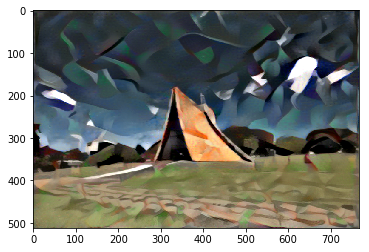

In [23]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss

# 取得原圖
x = preprocess_image(base_image_path)

num_iter = 10
prev_min_val = -1

# 設個閥值，如果improvement值小於這個值，就直接停止執行迴圈
improvement_threshold = float(0.0)

for i in range(num_iter):
    print("Starting iteration %d of %d" % ((i + 1), num_iter))
    start_time = time.time()

    # 執行L-BFGS優化器降低loss
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)

    if prev_min_val == -1:
        prev_min_val = min_val

    # 跟上一次的最小值相比，看進步多少
    improvement = (prev_min_val - min_val) / prev_min_val * 100

    print("Current loss value:", min_val, " Improvement : %0.3f" % improvement, "%")
    prev_min_val = min_val
        
    end_time = time.time()
    print("Iteration %d completed in %ds \n" % (i + 1, end_time - start_time))

    # 最後一個迴圈顯示圖片
    if i >= num_iter - 1:
        showimg(x)
        
    # 檢查是否大於閥值，沒有大於就直接中斷
    if improvement_threshold is not 0.0:
        if improvement < improvement_threshold and improvement is not 0.0:
            print("Improvement (%f) is less than improvement threshold (%f). Early stopping script." %
                    (improvement, improvement_threshold))
            showimg(x)